# Speaker Gender Classification

## Introduction

In this notebook we will do a gender classification over speech. we will use LibriSpeech dev-clean corpus.
Please find and download part of the LibriSpeech [here](http://www.openslr.org/12/) and save in this folder.  This database contains directories with ids. Each id represents one speaker and contains audio files associated with that speaker. You will also find a file that indicates the gender of each speaker.

### Requirements
* pandas
* matplotlib
* seaborn
* tqdm
* librosa
* tensorflow
* keras

**Table of content**
### [Data Preprocessing](#I)

#### [Data Retrievel](#I_I)
* Firstly we will retrieve the audio tracks, stored in `LibriSpeech/dev-clean/speaker_id/chapter_id/audio_file.flac`. Since I don't have enough computational power to train whole corpus, in this notebook I'll choose randomly 15 male and 15 female speakers to use as dataset. If you have enough computation power feel free to use all dataset.

#### [Features extraction](#I_II)
* Secondly, we will extract MFCC coefficients from every track. We'll use librosa package for feature extraction. We'll keep the first 13 coeffiecents since they are enough to represent the shape of the spectrum.

#### [Explatory Data Analysis](#I_III)
* In this part we'll plot the distribution of our features and look for outliers and skewed distribution

#### [Train/Val/Test Split](#I_IV)
* And then we will split our data into train, validation and test sets.

### [Classification](#III)

* We will start with simple baseline methods, Naive Bayes Classifier, Logistic Regression and then we'll built Ensemble methods(Gradient Boosting and Random Forest) finally we'll implement Neural Networks and some deep learning models (CNNs and RNNs)
#### [GaussianNB](#III_I) 
#### [Logistic Regression](#III_II)       
#### [Random Forest](#III_III)    
#### [Gradient Boosting Trees](#III_IV)    
#### [Feed Forwad Neural Networks](#III_V)    
#### [Convolutional Neural Networks](#III_VI)    
#### [Recurrent Neural Networks](#III_VII)

### [Discussion](#IV)
* After we test all of our models we'll compare and understand why a specific one performed better from another


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import librosa
import glob
import os
import IPython.display as ipd

<a id='I'></a>
## Data Preprocessing

<a id='I_I'></a>
### Data Retrival

In [2]:
path = 'dev-clean/LibriSpeech/'
seed = 1

In [3]:
df = pd.read_csv(path+'SPEAKERS.TXT',comment=';',sep='|',header=None).rename(columns={0:'id',1:'sex',2:'subset',3:'minutes',4:'name'})
df.head()
df.sex=df.sex.str.strip()
df.subset=df.subset.str.strip()
df.id = df['id'].apply(pd.to_numeric)


df.head()

,id,sex,subset,minutes,name
0,14,F,train-clean-360,25.03,Kristin LeMoine
1,16,F,train-clean-360,25.11,Alys AtteWater
2,17,M,train-clean-360,25.04,Gord Mackenzie
3,19,F,train-clean-100,25.19,Kara Shallenberg
4,20,F,train-other-500,30.07,Gesine


Remove spekers doesn't belong to `dev-clean corpus`

In [4]:
all_speakers = df.loc[df.subset=='dev-clean']
all_speakers = all_speakers.set_index('id').loc[all_speakers.id.unique()].reset_index()
all_speakers.head()

,id,sex,subset,minutes,name
0,84,F,dev-clean,8.02,Christie Nowak
1,174,M,dev-clean,8.04,Peter Eastman
2,251,M,dev-clean,8.04,Mark Nelson
3,422,M,dev-clean,8.38,President Lethe
4,652,M,dev-clean,8.31,Scott Walter


In [5]:
all_speakers.sex.value_counts()

M    20
F    20
Name: sex, dtype: int64

In [6]:
all_speakers[all_speakers.sex=='F'].minutes.sum(), all_speakers[all_speakers.sex=='M'].minutes.sum()

(161.44999999999996, 161.82999999999998)

If we use whole dataset we will have classes which are balanced for all dataset.  We don't need to deal with it now, but if it were imbalanced we could use resampling(oversampling/undersampling), generate synhetic samples or we could change the performance metrics. Accuracy can be used to eval

In [7]:
np.random.seed(seed) # used to generate reproducible samples

Select randomly 15 male and 15 female speakers for training. If you want to choose different smaples feel free to change `num_samples`

In [8]:
num_speakers=15

female_speakers = all_speakers[all_speakers.sex=='F']
female_speakers = female_speakers.set_index('id').loc[female_speakers.id.unique()].reset_index()
idx = np.random.choice(female_speakers.index.values,num_speakers)
female_speakers = female_speakers.iloc[idx]

male_speakers = all_speakers[all_speakers.sex=='M']
male_speakers = male_speakers.set_index('id').loc[male_speakers.id.unique()].reset_index()
idx = np.random.choice(female_speakers.index.values,num_speakers)
male_speakers =  male_speakers.iloc[idx]

speakers = pd.concat([female_speakers,male_speakers]).sample(frac=1,random_state=seed)
speakers = speakers.set_index('id').loc[speakers.id.unique()].reset_index()


In [9]:
speakers

,id,sex,subset,minutes,name
0,2803,M,dev-clean,8.20,aquielisunari
1,2803,M,dev-clean,8.20,aquielisunari
2,2803,M,dev-clean,8.20,aquielisunari
3,1462,F,dev-clean,8.04,E. Tavano
4,3000,M,dev-clean,8.03,Brian von Dedenroth
5,2035,F,dev-clean,8.11,Sharon Bautista
6,3170,M,dev-clean,8.10,VOICEGUY
7,3170,M,dev-clean,8.10,VOICEGUY
8,3170,M,dev-clean,8.10,VOICEGUY
9,3170,M,dev-clean,8.10,VOICEGUY


In [10]:
speakers[speakers.sex=='F'].minutes.sum(), speakers[speakers.sex=='M'].minutes.sum()

(120.81, 121.31999999999998)

After sampling classes ara balanced again in terms of minutes of speech. But we'll face another problem. Since we need to have fixed size of frames this inspection is not useful right now. It'll be clear later

In [11]:
speakers = speakers[['id','sex']] #keep only id and sex attributes
speakers.head()

,id,sex
0,2803,M
1,2803,M
2,2803,M
3,1462,F
4,3000,M


<a id='I_II'></a>
### Feature Extraction

* We will use librosa package to extract features. Since first 13 MFCC coeffiecients are very powerful to describe the spectrum we'll keep only the first 13 coefficients.

**IMPORTANT NOTE**:
* Since the length of each track is different after extracting coefficients and we sample with 25 ms frequency we will get different frame size for each track. This will cause problem for machine learning. Because in machine learning algorithms we need to have a fixed size of input. To solve this problem we will use mean of each coefficient for each track so we'll have fixed size (1,13) for each input. There can be other solutions like padding or truncating. Actually mean is one extreme kind of truncating. We force each track exactly to have 1 frame. Ofcourse this will cause loss of data. But since we are using mean I think we will not suffer from that much.
    

In [12]:
numcep=13 #number of coefficients that will be kept
sampling_rate=22050 # 25 ms

In [13]:
def get_MFCC(filename, sampling_rate, numcep):
    """
    :param audio: audio sample from speaker
    :param sampling rate: sampling frequency
    :param numcep: number of cepstrums
    :return: mfcc coeffients
    """
    
    signal,sr = librosa.load(filename,sr=sampling_rate, mono=True)
    mfcc = librosa.feature.mfcc(signal,sr=sampling_rate,n_mfcc=numcep)
    mfcc = np.mean(mfcc, axis=1).reshape(1,-1) #mean of frame coefficients
    
    return mfcc

* Inspect one sample

In [14]:
file = 'dev-clean/LibriSpeech/dev-clean/6345/64257/6345-64257-0015.flac'
features=get_MFCC(file,sampling_rate,numcep)
print('Features shape: {}'.format(features.shape))

Features shape: (1, 13)


* Extracting features for each track

In [15]:
import_csv=True
csv_file = 'data.csv'
dataset = np.ndarray(shape=(0,numcep+1))
genders = np.ndarray(shape=(0,1))
files = []
if import_csv:
    dataset = pd.read_csv(csv_file,index_col=0)
else:
    for _,row in speakers.iterrows():
        id = row.id
        sex = 0 if row.sex == 'F' else 1
        for filename in tqdm(glob.iglob(path+'dev-clean/' + str(id) + '/**/*', recursive=True)):
            if filename.endswith('.flac'):
                files.append(filename)
                #compute MFCC features
                features = get_MFCC(filename,sampling_rate,numcep)
                features = np.append(features,np.array(sex).reshape(-1,1), axis=1)
                dataset = np.append(dataset,features, axis=0)


In [16]:
data = pd.DataFrame(dataset)
data.rename(columns={'13':'gender'},inplace=True) #for easy manipulation
# data.to_csv('data.csv') #For exporting dataset into a csv file


<a id='I_III'></a>
### Explatory Data Analysis

In [17]:
data.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,gender
count,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000
mean,-348.560172,114.839141,-16.935802,37.896692,-8.348886,7.496209,-12.530502,-2.651093,-6.426243,0.324648,-2.567515,-5.839378,3.189673,0.468401
std,58.480035,18.696044,22.577203,16.167329,11.857897,13.436234,8.019850,10.631449,6.194244,5.620402,4.200450,4.788620,3.656570,0.499133
min,-580.348938,61.065781,-103.232010,-18.738474,-41.767353,-40.505203,-38.023438,-28.815924,-27.779594,-16.970016,-17.170280,-21.504631,-7.474981,0.000000
25%,-373.577332,103.726120,-27.081168,26.678917,-16.625968,0.282195,-17.499874,-10.365983,-11.093349,-3.458590,-5.032251,-8.590101,0.542625,0.000000
50%,-346.523987,114.341835,-11.779500,39.431957,-8.075290,9.006979,-11.754571,-2.078765,-6.260871,-0.468436,-2.094715,-5.521032,3.216078,0.000000
75%,-319.925415,124.112343,-1.446836,48.243694,1.082655,15.208585,-6.632940,3.339970,-1.742385,3.468728,0.326906,-2.885097,5.743600,1.000000
max,-160.386887,171.033463,23.042019,86.732796,23.101646,49.327198,7.072770,33.078312,11.079936,16.172735,10.053016,10.563745,15.589996,1.000000


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1883 entries, 0 to 1882
Data columns (total 14 columns):
0         1883 non-null float64
1         1883 non-null float64
2         1883 non-null float64
3         1883 non-null float64
4         1883 non-null float64
5         1883 non-null float64
6         1883 non-null float64
7         1883 non-null float64
8         1883 non-null float64
9         1883 non-null float64
10        1883 non-null float64
11        1883 non-null float64
12        1883 non-null float64
gender    1883 non-null float64
dtypes: float64(14)
memory usage: 220.7 KB


* As we see here there are no null attributes and there are no categorical data. So we don't have to deal with deal with these problems.

In [19]:
def sephist(df,col):
    """
    This function is used to group by in plotting histogram
    :param df: data frame
    :param col rate:colon name
    :return female, male: Column values for male and female
    """
    female = df[df.gender == 0 ].iloc[:,col]
    male = df[df.gender == 1].iloc[:,col]
    
    return female, male

def plot_histogram(df,numcep):
    """
    Function to plot histogram of two groups(male female)
    :param df: data frame
    :param numcep:number of MFCC coefficients
    """
    f, ax = plt.subplots(numcep, sharey=True, figsize=(10, 20))
#     for col in df.columns[:-2]:
#         ax[col].hist(sephist(df,col)[0],bins=25,alpha=0.75, label='Female', color='r')
#         ax[col].hist(sephist(df,col)[1],bins=25,alpha=0.75, label='Male', color='b')
#         ax[col].legend(loc='upper right')
#         ax[col].set_title(col)

    for col in range(numcep):
        ax[col].hist((sephist(df,col)[0], sephist(df,col)[1]), bins=50, alpha=0.7, label=['female', 'male'], color=['r', 'b'])
        ax[col].legend(['female', 'male'])
        ax[col].legend(loc='upper right')
        ax[col].set_title(col)
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    

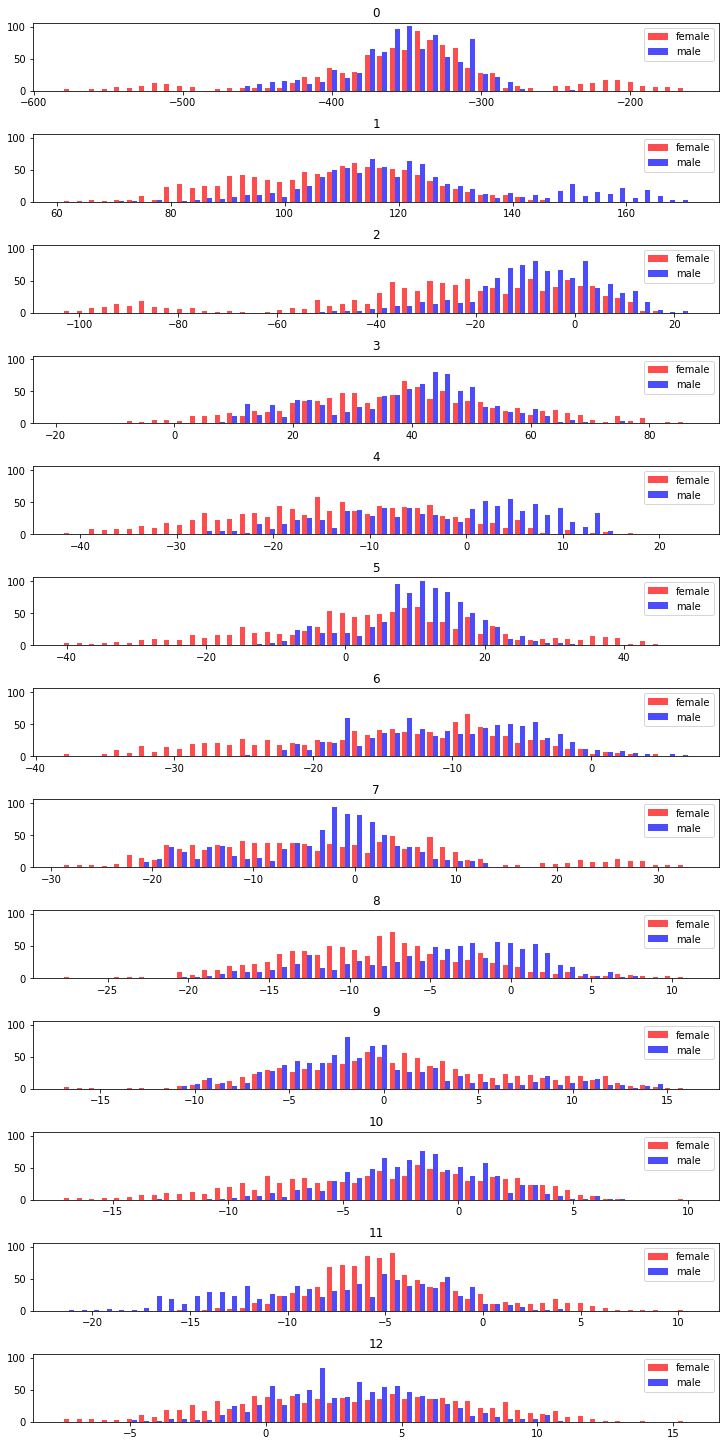

In [20]:
plot_histogram(data,numcep)

* We can see that features seem to have normally distibution. Some of them have some skew but they are not very different in both genders. 

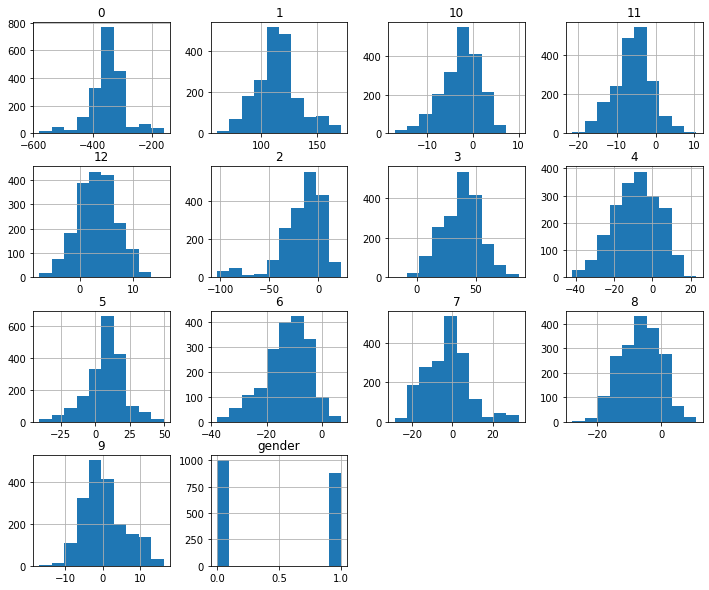

In [21]:
h=data.hist(figsize=(12,10))

Here we have the histogram of all dataset. They seem to have a distribution close to normal distribution

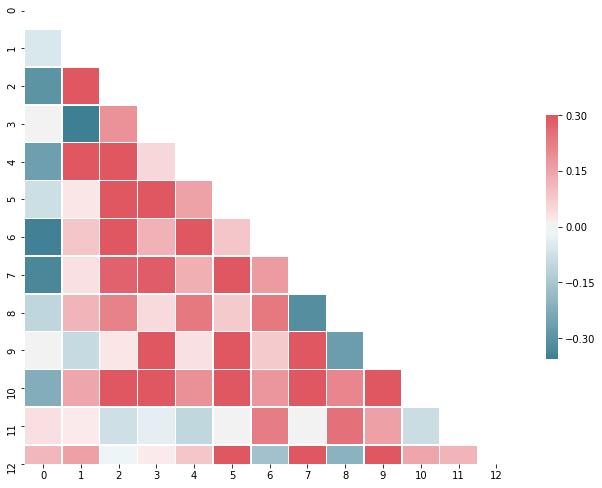

In [22]:
corr = data.iloc[:,:-1].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

h = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

* Here we have heatmap. We can observe that features aren't highly correlated since the correlation varies between -0.3 and 0.3

Final data preparation

In [23]:
genders = np.array(data.iloc[:,-1])
dataset = data.drop('gender',axis=1)
dataset = dataset.to_numpy()

In [24]:
print('Dataset shape: ',dataset.shape)
print('Genders shape: ',genders.shape)
print('Number of male speakers:', genders.sum())
print('Male Speakers Ratio:%', int(genders.sum()/genders.shape*100))

Dataset shape:  (1883, 13)
Genders shape:  (1883,)
Number of male speakers: 882.0
Male Speakers Ratio:% 46


* Here we see that we have 1883 samples and 882 of them are male. Now data isn't perfectly unbalanced, we might have small bias to the gender which is majority(female), but since the imbalance is not very much I don't think it'll effect our performace very much

<a id='I_IV'/></a>
### Train/Val/Test Split

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.utils import check_X_y
from sklearn.preprocessing import scale

Train/Test splitting

In [26]:
X_train, X_test, y_train, y_test = train_test_split(dataset, genders, test_size=0.2, random_state=seed, stratify=genders)
#Scaling data
X_train = scale(X_train)
X_test= scale(X_test)

Input validation

In [27]:
X_train, y_train = check_X_y(X=X_train, y=y_train)
X_test, y_test = check_X_y(X=X_test, y=y_test)

Train/Validation splitting

In [28]:
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = seed, stratify = y_train)

<a id='III'></a>
## Classification

<a id='III_I'></a>
### GaussianNB

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

In [30]:
estimators = []
estimators.append(('gnb', GaussianNB()))

pipeline_gnb = Pipeline(estimators)
pipeline_gnb.fit(X_train, y_train)

y_pred = pipeline_gnb.predict(X_test)
score = accuracy_score(y_test, y_pred)

print('Gaussian Naive Bayes accuracy on test set: {}\n'.format(score))
print('Classification Report:\n',classification_report(y_test, y_pred))

Gaussian Naive Bayes accuracy on test set: 0.7984084880636605

Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.71      0.79       200
         1.0       0.73      0.89      0.81       177

   micro avg       0.80      0.80      0.80       377
   macro avg       0.81      0.80      0.80       377
weighted avg       0.81      0.80      0.80       377



As it's seen our precision is worse in male(class=1) this is because we have bias towards to female speakers since we have more female speakers in our data set. But overall performance is not very bad because since our data has normal distibution naive bayes performs fair well enough. Also the strong conditionally independence assumption of Naive Bayes reduces the performance.

<a id='III_II'></a>
### Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

#  features and classifier in a single pipeline

estimators = []
estimators.append(('lr', LogisticRegression(random_state = seed,solver='liblinear')))

pipeline_lr = Pipeline(estimators)
pipeline_lr.set_params(lr__penalty='l2')

# Finding best value of C using validation set
scores = []
Cs = []
for C in tqdm(np.logspace(0, 2.5, 100)):
    pipeline_lr.set_params(lr__C=C) 
    pipeline_lr.fit(X_train_train,y_train_train)
    
    y_train_pred = pipeline_lr.predict(X_train_val)
    scores.append(accuracy_score(y_train_val, y_train_pred))
    
    Cs.append(C)

best_C_l2 = Cs[scores.index(max(scores))]
print ('best C = %2.4f with accuracy : %2.4f' %(best_C_l2, max(scores)))

# Performance of the tuned model on test set
pipeline_lr.set_params(lr__C=best_C_l2)
pipeline_lr.fit(X_train,y_train)

y_pred_lrRl2 = pipeline_lr.predict(X_test)
score = accuracy_score(y_test, y_pred_lrRl2)

print ('l2-Logistic regression classifer accuracy on test set : %2.6f' %score)
print('Classification Report:\n',classification_report(y_test, y_pred_lrRl2))

100%|██████████| 100/100 [00:01<00:00, 77.18it/s]

best C = 2.0092 with accuracy : 0.8576
l2-Logistic regression classifer accuracy on test set : 0.856764
Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.83      0.86       200
         1.0       0.82      0.89      0.85       177

   micro avg       0.86      0.86      0.86       377
   macro avg       0.86      0.86      0.86       377
weighted avg       0.86      0.86      0.86       377



* Now we saw another linear classifier, Logistic Regression. It outperformed Naive Bayes after hyperparameter tuning. I think the reason behind this is the conditionally independence of Naive Bayes which introduces bias.

<a id='III_III'></a>
### Random Forest

100%|██████████| 20/20 [00:04<00:00,  2.98it/s]


best n_estimators = 95 with accuracy : 0.9801
Random forest classifer accuracy on test set : 0.9894
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       200
         1.0       0.99      0.99      0.99       177

   micro avg       0.99      0.99      0.99       377
   macro avg       0.99      0.99      0.99       377
weighted avg       0.99      0.99      0.99       377



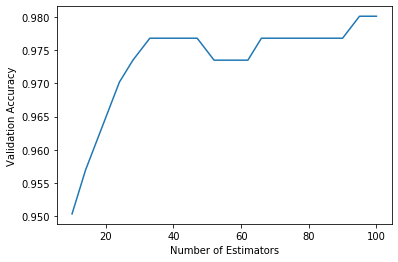

In [32]:
from sklearn.ensemble import RandomForestClassifier

estimators = []
estimators.append(('rf', RandomForestClassifier()))

pipeline_rf = Pipeline(estimators)
pipeline_rf.set_params(rf__random_state = seed)
    
# Finding best value of n_estimators using validation set
scores = []
n_estimators = []
for n_estimator in tqdm([int(i) for i in np.linspace(10, 100, 20)]):
    pipeline_rf.set_params(rf__n_estimators = n_estimator) 
    pipeline_rf.fit(X_train_train,y_train_train)
    y_train_pred = pipeline_rf.predict(X_train_val)
    scores.append(accuracy_score(y_train_val, y_train_pred))
    n_estimators.append(n_estimator)

best_n_estimator = n_estimators[scores.index(max(scores))]
print ('best n_estimators = %d with accuracy : %2.4f' %(best_n_estimator, max(scores)))

# Performance of the tuned model on test set
pipeline_rf.set_params(rf__n_estimators = best_n_estimator)
pipeline_rf.fit(X_train,y_train)

y_pred_rf = pipeline_rf.predict(X_test)
score = accuracy_score(y_test, y_pred_rf)

#Plot validation accuracy wrt number of estimators
plt.plot( n_estimators,scores)
plt.xlabel('Number of Estimators')
plt.ylabel('Validation Accuracy')

print ('Random forest classifer accuracy on test set : %2.4f' %score)
print('Classification Report:\n',classification_report(y_test, y_pred_rf))

* We see that Random Forest outperforms Naive Bayes and 
Logistic regression and reaches %98 accuracy. This decision tree based model performs well because some of the MFCC features are highly related the speaker gender.This provides us a making good decisin rules

<a id='III_IV'></a>

### Gradient Boosting Trees

100%|██████████| 20/20 [00:22<00:00,  1.64s/it]


best n_estimator = 374 with accuracy : 0.9801
Gradient Boosting Trees classifier accuracy on test set: 0.9920
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       200
         1.0       0.99      0.99      0.99       177

   micro avg       0.99      0.99      0.99       377
   macro avg       0.99      0.99      0.99       377
weighted avg       0.99      0.99      0.99       377



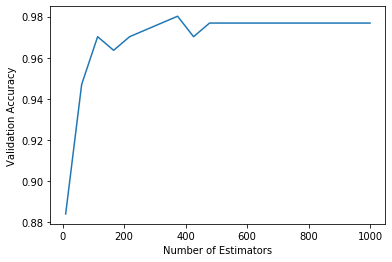

In [33]:
from sklearn.ensemble import GradientBoostingClassifier

# Define a gradient boosting tree classifier pipeline
estimators = []
estimators.append(('gb', GradientBoostingClassifier(random_state = seed)))

pipeline = Pipeline(estimators)

# Finding best value of n_estimators using validation set
# NOTE: Here i use only validation but to get getter performance you can use cross validaton 
#       if you have enough computation power
scores = []
n_estimators = []
for n_estimator in tqdm([int(i) for i in np.linspace(10, 1000, 20)]):
    pipeline.set_params(gb__n_estimators = n_estimator) 
    pipeline.fit(X_train_train,y_train_train)
    y_train_pred = pipeline.predict(X_train_val)
    scores.append(accuracy_score (y_train_val, y_train_pred))
    n_estimators.append(n_estimator)

best_n_estimator = n_estimators[scores.index(max(scores))]
print ('best n_estimator = %d with accuracy : %2.4f' %(best_n_estimator, max(scores)))

# Performance of the tuned model on test set
pipeline.set_params(gb__n_estimators = best_n_estimator)
pipeline.fit(X_train,y_train)

y_pred_gb = pipeline.predict(X_test)
score = accuracy_score(y_test, y_pred_gb)

#Plot validation accuracy wrt number of estimators
plt.plot( n_estimators,scores)
plt.xlabel('Number of Estimators')
plt.ylabel('Validation Accuracy')

print ('Gradient Boosting Trees classifier accuracy on test set: %2.4f' %score)
print('Classification Report:\n',classification_report(y_test, y_pred_gb))

* Again another ensemble method performs very well the motivation behind this is the same as Random Forest

<a id='III_V'></a>

### Feed Forward NN

In [34]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import np_utils
from keras.callbacks import Callback, EarlyStopping

Using TensorFlow backend.


In [35]:
# build neural network model
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(64, input_dim=dataset.shape[1], activation='relu'))
#     model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [36]:
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________


In [37]:
min_lr=1e-6
callbacks =[]
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                 mode="max",
                                                 min_lr=min_lr,
                                                 factor=.5,
                                                 patience=5,
                                                 verbose=1)
callbacks.append(reduce_lr)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)
callbacks.append(es_callback)

history = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=1, validation_split=0.2, callbacks=callbacks)

Train on 1204 samples, validate on 302 samples
Epoch 1/100
1204/1204 [==============================] - 0s 274us/step - loss: 0.5520 - accuracy: 0.7467 - val_loss: 0.4975 - val_accuracy: 0.7483
Epoch 2/100
1204/1204 [==============================] - 0s 42us/step - loss: 0.4374 - accuracy: 0.8131 - val_loss: 0.4270 - val_accuracy: 0.7980
Epoch 3/100
1204/1204 [==============================] - 0s 39us/step - loss: 0.3764 - accuracy: 0.8414 - val_loss: 0.3796 - val_accuracy: 0.8245
Epoch 4/100
1204/1204 [==============================] - 0s 37us/step - loss: 0.3342 - accuracy: 0.8580 - val_loss: 0.3413 - val_accuracy: 0.8377
Epoch 5/100
1204/1204 [==============================] - 0s 37us/step - loss: 0.2998 - accuracy: 0.8671 - val_loss: 0.3063 - val_accuracy: 0.8808
Epoch 6/100
1204/1204 [==============================] - 0s 42us/step - loss: 0.2708 - accuracy: 0.8879 - val_loss: 0.2745 - val_accuracy: 0.8974
Epoch 7/100
1204/1204 [==============================] - 0s 44us/step - loss

In [38]:
y_pred_ffnn = model.predict_classes(X_test)
score = accuracy_score(y_test, y_pred_ffnn)
print ('Feed Forward Neural Network accuracy on test set : %2.6f' %score)
print('Classification Report:\n',classification_report(y_test, y_pred_ffnn))

Feed Forward Neural Network accuracy on test set : 0.976127
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.97      0.98       200
         1.0       0.97      0.98      0.97       177

   micro avg       0.98      0.98      0.98       377
   macro avg       0.98      0.98      0.98       377
weighted avg       0.98      0.98      0.98       377



In [39]:
def plot_nn_hist(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

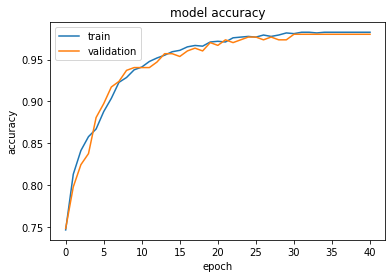

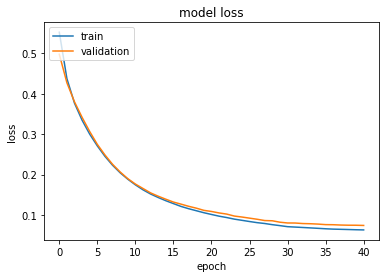

In [40]:
plot_nn_hist(history)

<a id='III_VI'></a>

### Convolutional Neural Networks

In [41]:
from keras.layers import Dense, Conv1D,LSTM, GlobalMaxPool1D, Dropout

In [42]:
def create_cnn_model():
    model = Sequential()
    model.add(Conv1D(64,10, activation='relu', input_shape=(numcep, 1)))
    model.add(GlobalMaxPool1D())
    model.add(Dense(1,activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

In [43]:
num_samples, num_features = dataset.shape
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(dataset.reshape(num_samples, num_features,1) , genders, test_size=0.2, random_state=seed, stratify=genders)

In [44]:
model = create_cnn_model()
hist = model.fit(X_train_cnn, y_train_cnn, batch_size=32, epochs=100, verbose=1, validation_split=0.2,callbacks=callbacks)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 4, 64)             704       
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________
None
Train on 1204 samples, validate on 302 samples
Epoch 1/100
1204/1204 [==============================] - 0s 179us/step - loss: 2.5037 - accuracy: 0.6096 - val_loss: 0.7479 - val_accuracy: 0.7020
Epoch 2/100
1204/1204 [==============================] - 0s 49us/step - loss: 0.5382 - accuracy: 0.7517 - val_loss: 0.4231 - val_accuracy: 0.7781
Epoch 3/100
1204/1204 [==================

1204/1204 [==============================] - 0s 60us/step - loss: 0.1348 - accuracy: 0.9527 - val_loss: 0.1615 - val_accuracy: 0.9371
Epoch 50/100
1204/1204 [==============================] - 0s 75us/step - loss: 0.1377 - accuracy: 0.9477 - val_loss: 0.1619 - val_accuracy: 0.9305
Epoch 51/100
1204/1204 [==============================] - 0s 81us/step - loss: 0.1351 - accuracy: 0.9535 - val_loss: 0.1624 - val_accuracy: 0.9305
Epoch 52/100
1204/1204 [==============================] - 0s 74us/step - loss: 0.1347 - accuracy: 0.9518 - val_loss: 0.1581 - val_accuracy: 0.9404

Epoch 00052: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 00052: early stopping


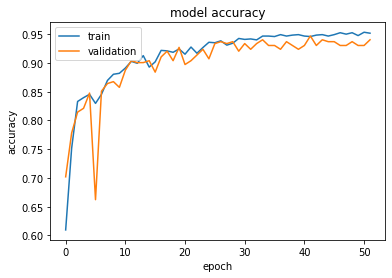

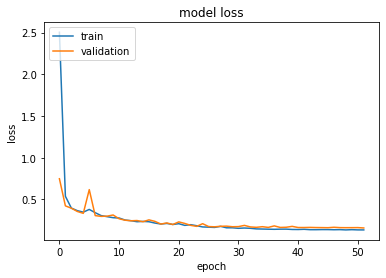

In [45]:
plot_nn_hist(hist)

In [46]:
y_pred_cnn = model.predict_classes(X_test_cnn)
score = accuracy_score(y_test_cnn, y_pred_cnn)
print ('One Layer CNN accuracy on test set : %2.6f' %score)
print('Classification Report:\n',classification_report(y_test_cnn, y_pred_cnn))

One Layer CNN accuracy on test set : 0.946950
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.94      0.95       200
         1.0       0.93      0.95      0.94       177

   micro avg       0.95      0.95      0.95       377
   macro avg       0.95      0.95      0.95       377
weighted avg       0.95      0.95      0.95       377



<a id='III_VII'></a>

### Recurrent Neural Networks

In [47]:
def singleLSTM(input_dim=(13,1)):
    model = Sequential()
    # LSTM Layer
    model.add(LSTM(128,input_shape=input_dim))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

In [48]:
model = singleLSTM()
hist = model.fit(X_train_cnn, y_train_cnn, batch_size=32, epochs=100, verbose=1, validation_split=0.2,callbacks=callbacks)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
None
Train on 1204 samples, validate on 302 samples
Epoch 1/100
1204/1204 [==============================] - 1s 939us/step - loss: 0.5727 - accuracy: 0.6661 - val_loss: 0.5098 - val_accuracy: 0.7252
Epoch 2/100
1204/1204 [==============================] - 1s 510us/step - loss: 0.4738 - accuracy: 0.7508 - val_loss: 0.4532 - val_accuracy: 0.7517
Epoch 3/100
1204/1204 [==============================] - 1s 544us/step - loss: 0.4297 - accuracy: 0.7824 - val_loss: 0.4315 - val_accuracy: 0.8146
Epoch 4/100
1204/12

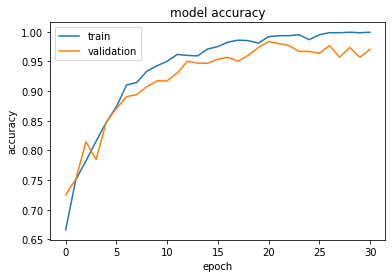

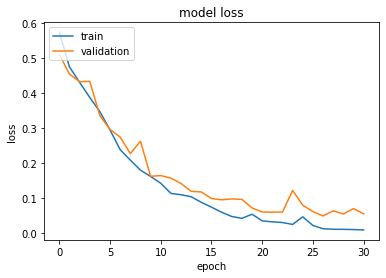

In [49]:
plot_nn_hist(hist)

In [50]:
y_pred_lstm = model.predict_classes(X_test_cnn)
score = accuracy_score(y_test_cnn, y_pred_lstm)
print ('One Layer LSTM on test set : %2.6f' %score)
print('Classification Report:\n',classification_report(y_test_cnn, y_pred_lstm))

One Layer LSTM on test set : 0.989390
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       200
         1.0       0.99      0.99      0.99       177

   micro avg       0.99      0.99      0.99       377
   macro avg       0.99      0.99      0.99       377
weighted avg       0.99      0.99      0.99       377



<a id='IV'></a>
### Discussion

**Accuracy Performances**

| Model | Accuracy  |
|------|------|
|   Gaussian NB  | 0.7984|
|   Logistic Regression| 0.8567|
|   Random Forest  | 0.9894|
|   Gradient Boosting Trees| 0.9920|
|   FFN  |  0.9761|
|   CNN  |  0.9469|
|   RNN  | 0.9893|

* In this problem Naive Bayes performs worst because it has strong  conditional independence assumption. This introduces bias.
* Logistic regression perfors slightly better than Naive Bayes. It has less bias wrt Naive Bayes due to lacking of conditional independence assumption. However wrt ensemble methods or neural networks it is far behind by their performance
* It's seen that for this dataset ensemble methods perform best. These decision tree based models perform good because MFCC features are highly correlated to gender of the speaker. This makes eaiser to create good decision rules
* Simply one hidden layer FFN performs suprisingly very well. We see the power of universal approximation power of neural nets. I believe if we fine tune layers and number of units we could achieve a better performance.
* One Layer CNN with drop out layer performs very well I believe this is because it detects latent features in the spectrum which helps us to distinguish genders. But with the current setting it can't outperform FFN. Maybe if we change number of convolutional layers and number of units we could get better performance. This requires fine tuning.
* Finally one layer simple LSTM performs astonishingly well. I think this is thanks to temporal correlation between frames. Since they are a part of continuous speech they have some temporal dependance.

* Overall observation: 
    * In general we saw that we have better performance for females. This is caused by the small imbalance in our dataset(the 15+15 samples that I draw from all dataset). We have %46 male and %54 female. This introduces a small bias. To deal with we could upsample or downsamle or change our metrics.
    * Secondly, when I extract features I got the mean of each feature. The reason is tracks have different lenth and when we sample them with sampling rate=22050(25 ms each frame) we have diffent size of frame for each track. For ML algorithms we need to fix the size. There are many solutions for this. For example choose a fixed size. Truncate samples whose frame size are larger than it and do padding operation for samples whose frame size are smaller than it. Or,as I did we can get the mean for each feature and return fixed size as 1. The advantage of mean is every frame has contribution to final mean values. But the problem of the mean is we highly reduce the number of data. For this problem mean seems to work pretty well. But other datasets and problems the other solutions can be better. Actually, for further works the performance of these methods can be compared.
    * Final Word! These results are valid only for this problem. Here we saw that Random Forest is the best for this classificatiob task. But for other problems even simple Naive Bayes could be better. Never forget! **No Free Lunch!**